<a href="https://colab.research.google.com/github/atbasu/DL4H_1433_Experiments_With_Sleep/blob/main/DL4H_1433_Experiments_With_Sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation

Quality sleep plays a vital role in proper mental and physical health, quality of life, and safety of an individual. Sleep deficiency is a very common public health problem, and an estimated 50-70 million Americans have chronic sleep disorders[11]. Reduced or abnormal sleep can lead to several physical and mental risk factors including injury/accidents, depression, and heart disease, making it a very important topic for medical research. Sleep stage scoring is the process of monitoring Electroencephalogram (EEG) signals to determine brain activity and diagnose sleep disorders.

Manual sleep quality classification using experts and domain knowledge is a very labor-intensive and time-consuming task, which requires a large amount of medical resources for recording, labeling, and classifying each epoch of data. In addition, the scoring procedure used by human experts is based on generalized
guidelines and is no doubt prone to error. For these reasons, automated sleep stage classification has become a large area of study for deep learning applications. Deep learning models are able to handle large amounts of data and form a final complete classifier using patterns learned from batches and sequences of information presented during training. Deep learning models are
also able to learn and automatically determine the important underlying features from sleep signal and patient demographic information, reducing the need for costly and complex feature engineering and prior knowledge of EEG analysis.

In this notebook, we will utilize publicly available sleep sensor datasets and apply a sequence-to-sequence deep learning model using both convolution networks and transformers with self-attention to achieve automatic sleep stage classification.

# Step 1 - Decompress the dataset

Connect to the Google Drive location where the sleep data has been stored as compressed zip file and unzip the files.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -Z1 "/content/drive/MyDrive/Colab Notebooks/DLH/eeg_fpz_cz.zip" | head -10 | sed 's| |\\ |g' | xargs unzip "/content/drive/MyDrive/Colab Notebooks/DLH/eeg_fpz_cz.zip"
# !unzip "/content/drive/MyDrive/Colab Notebooks/DLH/eeg_fpz_cz.zip"

# Step 2 - Set up python evironment

In order to train a sequence-to-sequence deep learning model using pytorch we will require the following libraries:
## Need to fill out this section 

In [ ]:
import os
import csv
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
from typing import Union, Sequence
import collections
from sklearn.metrics import confusion_matrix
import time
from matplotlib import pyplot
from datetime import datetime as dt 

#Step 3 - Set up the lab environment and hyperparameters



1.   Pick a random seed to initlalise the random number generators
2.   Set the environment to use the GPU if available, otherwise default to the CPU
3.   define the location of the data
4.   define some the parameters of the data experiment such as the number and name of prediction classes 
5.   Initialise a list of scientific logs to document the experiment for ex post facto analysis 
6.   define model hyper parameters




In [ ]:
# 1
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#3
data_dir = '/content/eeg_fpz_cz'

#4
num_folds = 20
classes = ['W', 'N1', 'N2', 'N3', 'REM']
n_classes = len(classes)
n_oversampling = 30000

#5
scientific_log = []

#6
hyperparams = {
    'epochs' : 120,
    'batch_size' : 20,
    'num_units' : 128,
    'embed_size' : 10,
    'input_depth' : 3000,
    'n_channels' : 100,
    'bidirectional' : False,
    'use_attention' : True,
    'lstm_layers' : 2,
    'attention_size' : 64,
    'beam_width' : 4,
    'use_beamsearch_decode' : False,
    'max_time_step' : 10,  # 5 3 second best 10# 40 # 100
    'output_max_length' : 10 + 2,  # max_time_step +1
    'akara2017' : True,
    'test_step' : 5
}

# Step 4 - Define the Dataloader

1. Initializing the DataLoader - the Data Loader should be initialised with the following parameters:
  1. data_dir - directory where npz files are stored
  2. n_folds - determines the number of folds the data will be divided into(can be tweaked for experimentation)
  3. fold_idx - determines which fold will be used for the test data cohort(can be tweaked for experimentation)
  4. classes - for this experiment the network needs to predict the sleep stages so they are the following values ['W', 'N1', 'N2', 'N3', 'REM']
2. Load the npz files - The input data has been preprocessed into 17 pre-processed npz files. Each npz files contains, among other things, the following three data points:
  1. Data - needs to be squeezed out of a list and then converted to a float
  2. Labels - needs to be converted to int
  3. sampling_rate - 30s
3. Split the data and labels into Train and Test cohorts - when splitting the data the three hyperparameter that can be tweaked when experimenting are:
  1. seq_len - determined by hyper paramter 'max_time_step'..fill this in...defuaults to 10 
  2. shuffle - shuffle randomises the data in the cohorts. Defaults to True.
  3. n_files - determines the number of files that will be used when creating the Train and Test Cohorts. Defaults to None, in which case it uses all.


In [ ]:
'''
https://github.com/akaraspt/deepsleepnet
Copyright 2017 Akara Supratak and Hao Dong.  All rights reserved.
'''
#Loads the data from the npz preprocessed files and builds the training/test set
class SeqDataLoader(object):

    def __init__(self, data_dir, n_folds, fold_idx,classes):
        self.data_dir = data_dir
        self.n_folds = n_folds
        self.fold_idx = fold_idx
        self.classes = classes

    def load_npz_file(self, npz_file):
        """Load data_2013 and labels from a npz file."""
        scientific_log.append("In function load_npz_file :")
        
        with np.load(npz_file) as f:
            data = f["x"]
            labels = f["y"]
            sampling_rate = f["fs"]
        
        scientific_log.append("Exiting function load_npz_file :")
        
        return data, labels, sampling_rate

    def _load_npz_list_files(self, npz_files):
        """Load data_2013 and labels from list of npz files."""
        scientific_log.append("In function SeqDataLoader._load_npz_list_files :")

        data = []
        labels = []
        fs = None

        for npz_f in npz_files:
            scientific_log.append("  Loading {} ...".format(npz_f))
            tmp_data, tmp_labels, self.sampling_rate = self.load_npz_file(npz_f)
            if fs is None:
                fs = self.sampling_rate
            elif fs != self.sampling_rate:
                raise Exception("Found mismatch in sampling rate.")

            # Reshape the data_2013 to match the input of the model - conv2d
            tmp_data = np.squeeze(tmp_data)

            # Casting
            tmp_data = tmp_data.astype(np.float32)
            tmp_labels = tmp_labels.astype(np.int32)

            # normalize each 30s sample such that each has zero mean and unit vairance
            tmp_data = (tmp_data - np.expand_dims(tmp_data.mean(axis=1),axis= 1)) / np.expand_dims(tmp_data.std(axis=1),axis=1)

            data.append(tmp_data)
            labels.append(tmp_labels)
        
        scientific_log.append("Exiting function SeqDataLoader._load_npz_list_files :")
        
        return data, labels

    def load_data(self, seq_len = 10, shuffle = True, n_files=None):
        # Remove non-mat files, and perform ascending sort
        scientific_log.append("In function SeqDataLoader.load_data :")
        
        allfiles = os.listdir(self.data_dir)
        npzfiles = []

        for idx, f in enumerate(allfiles):
            if ".npz" in f:
                npzfiles.append(os.path.join(self.data_dir, f))
        npzfiles.sort()

        if n_files is not None:
            npzfiles = npzfiles[:n_files]

        # randomize the order of the file names just for one time!
        r_permute = np.random.permutation(len(npzfiles))
        filename = "r_permute.npz"
        if (os.path.isfile(filename)):
            with np.load(filename) as f:
                r_permute = f["inds"]
        else:
            save_dict = {
                "inds": r_permute,

            }
            np.savez(filename, **save_dict)

        npzfiles = np.asarray(npzfiles)[r_permute]
        train_files = np.array_split(npzfiles, self.n_folds)
        subject_files = train_files[self.fold_idx]


        train_files = list(set(npzfiles) - set(subject_files))
      
        # Load training and validation sets
        scientific_log.append("\n========== [Fold-{}] ==========\n".format(self.fold_idx))
        scientific_log.append("Load training set:")
        
        data_train, label_train = self._load_npz_list_files(train_files)
        
        scientific_log.append(" ")
        scientific_log.append("Load Test set:")
        
        data_test, label_test = self._load_npz_list_files(subject_files)
        
        scientific_log.append(" ")

        scientific_log.append("Training set: n_subjects={}".format(len(data_train)))
        
        n_train_examples = 0
        for d in data_train:
            scientific_log.append(d.shape)
            n_train_examples += d.shape[0]
        
        scientific_log.append("Number of examples = {}".format(n_train_examples))
        scientific_log.append("{}".format(print_n_samples_each_class(np.hstack(label_train),self.classes)))
        scientific_log.append(" ")
        scientific_log.append("Test set: n_subjects = {}".format(len(data_test)))
        
        n_test_examples = 0
        for d in data_test:
            scientific_log.append(d.shape)
            n_test_examples += d.shape[0]
        
        scientific_log.append("Number of examples = {}".format(n_test_examples))
        scientific_log.append("{}".format(print_n_samples_each_class(np.hstack(label_test),self.classes)))
        scientific_log.append(" ")

        data_train = np.vstack(data_train)
        label_train = np.hstack(label_train)
        data_train = [data_train[i:i + seq_len] for i in range(0, len(data_train), seq_len)]
        label_train = [label_train[i:i + seq_len] for i in range(0, len(label_train), seq_len)]
        if data_train[-1].shape[0]!=seq_len:
            data_train.pop()
            label_train.pop()

        data_train = np.asarray(data_train)
        label_train = np.asarray(label_train)

        data_test = np.vstack(data_test)
        label_test = np.hstack(label_test)
        data_test = [data_test[i:i + seq_len] for i in range(0, len(data_test), seq_len)]
        label_test = [label_test[i:i + seq_len] for i in range(0, len(label_test), seq_len)]

        if data_test[-1].shape[0]!=seq_len:
            data_test.pop()
            label_test.pop()

        data_test = np.asarray(data_test)
        label_test = np.asarray(label_test)

        # shuffle
        if shuffle is True:
            # training data_2013
            permute = np.random.permutation(len(label_train))
            data_train = np.asarray(data_train)
            data_train = data_train[permute]
            label_train = label_train[permute]

            # test data_2013
            permute = np.random.permutation(len(label_test))
            data_test = np.asarray(data_test)
            data_test = data_test[permute]
            label_test = label_test[permute]

        scientific_log.append("Exiting function SeqDataLoader.load_data")
       
        return data_train, label_train, data_test, label_test

In [ ]:
def print_n_samples_each_class(labels,classes):
    class_dict = dict(zip(range(len(classes)),classes))
    unique_labels = np.unique(labels)
    for c in unique_labels:
        n_samples = len(np.where(labels == c)[0])
        print("{}: {}".format(class_dict[c], n_samples))

# Step 5 - create dataset for batching

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
      self.x = data
      self.y = labels

    def __len__(self):
      return len(self.x)

    def __getitem__(self, index):
      return (self.x[index], self.y[index])

#Step 6 - Load Data using previously defined paramaters

As mentioned in Step 4, when defining the Dataloader, the fold_idx paramater is used to select which fold will be used as the test data. In the code below we use the very first fold(0).

One way to get a robust understanding of the performance of the model on the current data set might be to loop through every fold as the test data set and averaging out the performance across each fold.

In [ ]:
#Load data from files
sleep_data_loader = SeqDataLoader(data_dir, num_folds, fold_idx=0 , classes=classes) 
X_train, y_train, X_test, y_test = sleep_data_loader.load_data(seq_len=hyperparams['max_time_step'])

X_train = X_train[:(X_train.shape[0] // hyperparams['max_time_step']) * hyperparams['max_time_step'], :]
y_train = y_train[:(X_train.shape[0] // hyperparams['max_time_step']) *hyperparams['max_time_step']]

X_train = np.reshape(X_train,[-1,X_test.shape[1],X_test.shape[2]])
y_train = np.reshape(y_train,[-1,y_test.shape[1],])

scientific_log.append("X_train shape : {}".format(X_train.shape))
scientific_log.append("X_train[10] : {}".format(X_train[10]))
scientific_log.append("y_train shape :{}".format(y_train.shape))
scientific_log.append("y_train[10] : {}".format(y_train[10]))

#Step 7 - Build datasets

1. define a function to convert the different class labels to a one hot encoded vector.
2. define a function to collate all the one hote vectors
3. define a function to use Dataloader from the pytorch library to combines the test and training dataset with a respective sampler, and return an iterable over the batched test and train dataset.
4. prepare the train and test data for batching in a CustomDataset object
5. batch the data


In [ ]:
"""
https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/26
"""
#1
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes)
    return y[labels] 

#2    
def my_collate(batch):
  scientific_log.append("In function my_collate :")
  
  X = []
  Y = []
  for (x, y) in batch:
    '''add_to_Y = []
    for val in y:
      one_hot_y = one_hot_embedding(val, 5).numpy()
      add_to_Y.append(one_hot_y)'''
    Y.append(y) #add_to_Y
    X.append(x)

  scientific_log.append("Exiting function my_collate")
  return torch.FloatTensor(X), torch.FloatTensor(Y)

#3
def load_data(train_dataset, test_dataset, batch_size):
  scientific_log.append("In function load_data :")
  
  train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=my_collate)
  test_loader = DataLoader(test_dataset, batch_size, collate_fn=my_collate)
  
  scientific_log.append("Exiting function load_data")
  return train_loader, test_loader

#4
scientific_log.append("Initialising CustomDataset with X_train and y_train")
train_dataset = CustomDataset(X_train, y_train)
scientific_log.append("Initialising CustomDataset with X_test and y_test")
test_dataset = CustomDataset(X_test, y_test)

#5
train_loader, test_loader = load_data(train_dataset, test_dataset, batch_size=hyperparams["batch_size"])
scientific_log.append(" train data length : {}".format(len(train_loader)))
scientific_log.append(" test data length : {}".format(len(test_loader)))

#Step 8 - Define helper functions for model training and analysis

1. _get_compressed
2. _calc_pad - a function to calculate the exact pad size based on model parameters
3. get_pad - a function to create paddings for the kernel in a CNN model
4. evaluate_metrics - give the confusion matrix and the prediciton classes, generate different metrics for evaluating model performance
5. print_results - a function that takes the confusion matrix and experiment resutls as input and prettyprints it for ease of human consumption.

In [ ]:
'''
https://github.com/CyberZHG/torch-same-pad
'''
#1
def _get_compressed(item: Union[int, Sequence[int]], index: int):
    if isinstance(item, collections.Sequence):
        return item[index]
    return item
#2
def _calc_pad(size: int,
              kernel_size: int = 3,
              stride: int = 1,
              dilation: int = 1):
    pad = (((size + stride - 1) // stride - 1) * stride + kernel_size - size) * dilation
    return pad // 2, pad - pad // 2
#3
def get_pad(size: Union[int, Sequence[int]],
            kernel_size: Union[int, Sequence[int]] = 3,
            stride: Union[int, Sequence[int]] = 1,
            dilation: Union[int, Sequence[int]] = 1):
    len_size = 1
    if isinstance(size, collections.Sequence):
        len_size = len(size)
    pad = ()
    for i in range(len_size):
        pad = _calc_pad(size=_get_compressed(size, i),
                        kernel_size=_get_compressed(kernel_size, i),
                        stride=_get_compressed(stride, i),
                        dilation=_get_compressed(dilation, i)) + pad
    return pad
#4
def evaluate_metrics(cm,classes):
    n_classes = len(classes)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV, TP, FN

#5
def print_results(cm, results, labels, TP, FN, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    scientific_log.append("In function print_results")
    
    print ("Confusion matrix:")
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    scientific_log.append(" printing header of Confusion Matrix")
    
    print("    " + empty_cell + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    
    scientific_log.append(" printing rows of Confusion Matrix")
    
    for i, label1 in enumerate(labels):
        print("    %{0}s({1})".format(columnwidth,int(TP[i] + FN[i])) % label1,end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
    print("Model Evaluation Results:")
    
    scientific_log.append(" printing header of Model Evaluation Results")
    
    print("    " + empty_cell + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    
    scientific_log.append(" printing rows of Model Evaluation Results")
    
    for label,values in results.items():
        print( empty_cell + "    %{0}s".format(columnwidth) % label,end=" ")
        for j in range(len(values)):
            cell = "%{0}.1f".format(columnwidth) % values[j]
            if hide_zeroes:
                cell = cell if float(values[j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if values[j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()


#Step 9 - Build the Network
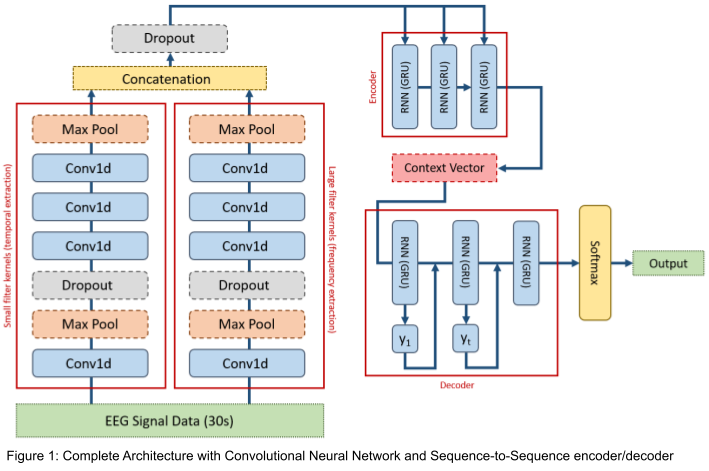




## Step 9.1 - Define the CNN Architecture

As part of our experiment we wanted to see the impact of each component of the nerual network towards learning the underlying patterns in sleep data. So to start we created a CustomCNN class that we could then modify to work as both a stand alone predictor and in tandem with the larger architecture.

### Network Shape

Small Filter Convolution:

(10)Conv1d\[50,6](64) -> Activation(F.relu) -> Pool(Maxpool1d\[8,8]) -> Dropout -> 
(64)Conv1d\[8,1](128) -> Activation(F.relu) ->
(128)Conv1d\[8,1](128) -> Activation(F.relu) ->
(128)Conv1d\[8,1](128) -> Activation(F.relu) -> Pool(Maxpool1d\[4,4])

Large Filter Convolution:

(10)Conv1d\[400,50](64) -> Activation(F.relu) -> Pool(Maxpool1d\[4,4]) -> Dropout -> 
(64)Conv1d\[6,1](128) -> Activation(F.relu) ->
(128)Conv1d\[6,1](128) -> Activation(F.relu) ->
(128)Conv1d\[6,1](128) -> Activation(F.relu) -> Pool(Maxpool1d\[2,2])

Aggregate Network:
(Small + Large) -> Dropout -> Activation(F.relu) -> Activation(F.relu) -> Softmax

In [ ]:
class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()
    # Use a mixture of small filters to extract temporal info
    # and large filters to extract frequency information

    self.csmall1 = nn.Conv1d(10, 64, kernel_size=50, stride=6)
    self.csmall2 = nn.Conv1d(64, 128, kernel_size=8, stride=1)
    self.csmall3 = nn.Conv1d(128, 128, kernel_size=8, stride=1)
    self.csmall4 = nn.Conv1d(128, 10, kernel_size=8, stride=1)
    
    self.clarge1 = nn.Conv1d(10, 64, kernel_size=400, stride=50)
    self.clarge2 = nn.Conv1d(64, 128, kernel_size=6, stride=1)
    self.clarge3 = nn.Conv1d(128, 128, kernel_size=6, stride=1)
    self.clarge4 = nn.Conv1d(128, 10, kernel_size=6, stride=1)

    self.p1 = nn.MaxPool1d(8, stride=8)
    self.p2 = nn.MaxPool1d(4, stride=4)
    self.p3 = nn.MaxPool1d(2, stride=2)

    self.drop = nn.Dropout(p=0.5)

  def forward(self, x):

    batch_size = x.shape[0]
    #Small Filter Convolution
    scientific_log.append("0O-Starting CustomCNN forward pass-O0")
    scientific_log.append(" applying small filter convolution on x : {0}".format(x))
    
    small = F.relu(self.csmall1(x))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(10, 64, kernel_size=50, stride=6) to x, resulting in small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))
    # Must calculate the padding size: (2*(output-1) - input - kernel)*(1 / stride)
    scientific_log.append(" setting padding size : {0}, kernel size : {1}, stride : {2}, dilation : {3}".format(64,50,5,1))
    
    padding = get_pad(size=64,
                    kernel_size=50,
                    stride=5,
                    dilation=1)
    small = F.pad(small, pad=padding)
    
    scientific_log.append(" applying padding to small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))    
    
    small = self.p1(small)
    
    scientific_log.append(" applying nn.MaxPool1d(8,8) to small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))
    
    small = self.drop(small)
    
    scientific_log.append(" applying nn.Dropout(p=0.5)to small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))

    # consecutive convolution
    small = F.relu(self.csmall2(small))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(64, 128, kernel_size=8, stride=1) to small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))
    
    small = F.relu(self.csmall3(small))
    scientific_log.append(" applying F.relu to nn.Conv1d(128, 128, kernel_size=8, stride=1) to small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))
    
    small = F.relu(self.csmall4(small))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(128, 128, kernel_size=8, stride=1) to small : {0}".format(small))
    scientific_log.append(" small shape = {}".format(small.shape))
    # max pooling with padding
    scientific_log.append(" setting padding size : {0}, kernel size : {1}, stride : {2}, dilation : {3}".format(128,8,1,1))
    scientific_log.append(" small shape = {}".format(small.shape))
    
    padding = get_pad(size=128,
                    kernel_size=8,
                    stride=1,
                    dilation=1)
    small = F.pad(small, pad=padding)
    
    scientific_log.append(" applying padding to small : {0}".format(small)) 
    scientific_log.append(" small shape = {}".format(small.shape)) 
    
    small = self.p2(small)
    
    scientific_log.append(" applying nn.MaxPool1d(4, stride=4) to small : {0}".format(small))  
    scientific_log.append(" small shape = {}".format(small.shape))

    #Large Filter Convolution
    scientific_log.append(" applying large filter convolution on x : {0}".format(x))
    
    large = F.relu(self.clarge1(x))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(10, 64, kernel_size=400, stride=50) to x, resulting in large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))
    scientific_log.append(" setting padding size : {0}, kernel size : {1}, stride : {2}, dilation : {3}".format(64,50,5,1))
    
    padding = get_pad(size=64,
                    kernel_size=400,
                    stride=50,
                    dilation=1)
    large = F.pad(large, pad=padding)
    
    scientific_log.append(" applying padding to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))    
    
    large = self.p2(large)
    
    scientific_log.append(" applying nn.MaxPool1d(4, stride=4) to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))
    
    large = self.drop(large)
    
    scientific_log.append(" applying nn.Dropout(p=0.5)to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))

    # consecutive convolution
    large = F.relu(self.clarge2(large))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(64, 128, kernel_size=6, stride=1) to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))
    
    large = F.relu(self.clarge3(large))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(128, 128, kernel_size=6, stride=1) to large : {0}".format(large))
    scientific_log.append(" larege shape = {}".format(large.shape))
    
    large = F.relu(self.clarge4(large))
    
    scientific_log.append(" applying F.relu to nn.Conv1d(128, 128, kernel_size=6, stride=1) to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))
    scientific_log.append(" setting padding size : {0}, kernel size : {1}, stride : {2}, dilation : {3}".format(128,6,1,1))
    
    padding = get_pad(size=128,
                    kernel_size=6,
                    stride=1,
                    dilation=1)
    large = F.pad(large, pad=padding)
    
    scientific_log.append(" applying padding to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))   
    
    large = self.p3(large)
    
    scientific_log.append(" applying nn.MaxPool1d(2, stride=2) to large : {0}".format(large))
    scientific_log.append(" large shape = {}".format(large.shape))

    # Aggregate Network
    concat = torch.cat((small, large), dim=2)
    
    scientific_log.append(" concatetnating small and large, concat shape = {}".format(concat.shape))
    #concat = concat.view(concat.shape[0], -1)
    #print(concat.shape)
    
    out = self.drop(concat)
    
    scientific_log.append(" applying nn.Dropout(p=0.5) to concat, resulting in out : {0}".format(out))
    scientific_log.append(" out shape = {}".format(out.shape))
    
    scientific_log.append("xX-Terminating CustomCNN forward pass-Xx")
    
    return out

#model = CustomCNN()
#model.to(device)

##Step 9.2 - Define an Encoder

Rather than build the original encoder, we wanted to observe the impact of single layered Gated Recurrent Unit RNN when used to encode the output of the CNN architecture defined above.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        #self.embedding = nn.Embedding(62, hyperparams['embed_size'])
        self.gru = nn.GRU(62, hyperparams['embed_size'])

    def forward(self, x):
        #print("CURR X (ENCODE):")
        embed = x > .05
        embed = embed.to(torch.long)
        embed = embed.to(torch.float)
        #print(embed.shape)
        #print(embed)
        #embedded = self.embedding(x)
        
        scientific_log.append("0O-Starting Encoder forward pass-O0")
        
        output, hidden = self.gru(embed)
        #print(f"encoder output: {output.shape}")
        #print(f"encoder hidden: {hidden.shape}")
        
        scientific_log.append(" applying nn.GRU(3000, {0}) to x : {0}".format(hyperparams['num_units'], x))
        scientific_log.append("  resulting in:")
        scientific_log.append("   output = {}".format(output))
        scientific_log.append("   output shape = {}".format(output.shape))
        scientific_log.append("   hidden = {}".format(hidden))
        scientific_log.append("   hidden shape = {}".format(hidden.shape))
        scientific_log.append("xX-Terminating Encoder forward pass-Xx")

        output = output.view(output.shape[0], -1)

        return output

## Step 9.3 - Define a Decoder

Similarly with the decoder we decided to keep it simple 

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
       
        self.rnn = nn.GRU(input_size=5, hidden_size=100, batch_first=True)
        
        self.linear1 = nn.Linear(100, 50)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(50, 5)
    
    def forward(self, x, hiddens):
        scientific_log.append("0O-Starting Decoder forward pass-O0")
        
        batch_size = x.shape[0]
        
        scientific_log.append(" setting batch size : {0}".format(batch_size))
        scientific_log.append(" setting hidden : {0}".format(hiddens))
        scientific_log.append("  hidden shape : {0}".format(hiddens.shape))
        
        hidden_dim = hiddens.unsqueeze(0)
        
        scientific_log.append("  unsqeezing hidden, resulting in hidden_dim, {0}".format(hidden_dim))
        scientific_log.append("  hidden_dim shape : {0}".format(hidden_dim.shape))
        #hidden_dim = torch.flatten(hidden_dim, start_dim=1, end_dim=2)
        scientific_log.append("  applying torch.flatten(hidden_dim, start_dim=1, end_dim=2), hidden_dim : {0}".format(hidden_dim))
        scientific_log.append("  hidden_dim shape : {0}".format(hidden_dim.shape))
        
        #print(f"decode hidden: {hidden_dim.shape}")
        x_dim = x.unsqueeze(1)
        #print(f"decode x: {x_dim.shape}")
        
        scientific_log.append(" x_dim : {}".format(x_dim))
        scientific_log.append(" x_dim shape: {}".format(x_dim.shape))
        
        '''if torch.cuda.is_available():
          scientific_log.append(" torch.cuda.is_available is true")
          x_dim = x_dim.cuda() 
          hidden_dim = hidden_dim.cuda()'''

        out, h_n = self.rnn(x_dim, hidden_dim)
        
        scientific_log.append(" applying nn.GRU(input_size=128, hidden_size=({0}*{1}), batch_first=True) to x_dim".format(hyperparams['max_time_step'],hyperparams['num_units']))
        scientific_log.append("  resulting in:")
        scientific_log.append("   out = {}".format(out))
        scientific_log.append("   out shape = {}".format(out.shape))
        scientific_log.append("   h_n = {}".format(h_n))
        scientific_log.append("   h_n shape = {}".format(h_n.shape))

        h_n = h_n.squeeze(0)
        
        scientific_log.append("   squeeze(0) on h_n = {}".format(h_n))
        scientific_log.append("   h_n shape = {}".format(h_n.shape))
       
        h_n = h_n.view(h_n.shape[0], -1)
        
        scientific_log.append("   view({0}, -1) on h_n final = {1}".format(h_n.shape[0],h_n))
        scientific_log.append("   h_n shape = {}".format(h_n.shape))

        preds = self.linear1(h_n)
        
        scientific_log.append("   applying nn.Linear(1280, 500) on h_n, resulting in preds : {}".format(preds))
        scientific_log.append("   preds  shape = {}".format(preds.shape))
        
        preds = self.act(preds)
        
        scientific_log.append("   applying nn.ReLU() on preds = {}".format(preds))
        scientific_log.append("   preds shape = {}".format(preds.shape))
        
        preds = self.linear2(preds)
       
        scientific_log.append("   applying nn.Linear(500, 50) on preds = {}".format(preds))
        scientific_log.append("   preds shape = {}".format(preds.shape))
        
        preds = self.act(preds)
        
        scientific_log.append("   applying nn.ReLU() on preds = {}".format(preds))
        scientific_log.append("   preds shape = {}".format(preds.shape))
        scientific_log.append("xX-Terminating Decoder forward pass-Xx")
        #preds = preds.view(batch_size, hyperparams['max_time_step'], -1)
        #h_n = h_n.view(batch_size, hyperparams['max_time_step'], -1)
        return preds, h_n

## Step 9.4 - Combine all the pieces

In [ ]:
class WholeModel(nn.Module):
    
    def __init__(self, cnn, encoder, decoder):
        super().__init__()
        self.cnn = cnn
        self.encoder = encoder
        self.decoder = decoder
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        scientific_log.append("0O-Starting WholeModel forward pass-O0")
        
        cnn_out = self.cnn(x)
        #print(f" X  {x.shape}")
        #print(f" X AFTER CNN {cnn_out.shape}")
        
        scientific_log.append(f" X AFTER CNN {cnn_out.shape}")
        
        preds = []
        batch_size = cnn_out.shape[0]
       
        scientific_log.append(f" BATCH SIZE: {batch_size}")
        
        seq_len = cnn_out.shape[1]
        
        scientific_log.append(f" SEQ LEN: {seq_len}")
        
        hidden = self.encoder(cnn_out)
        #print(f"ENCODE OUT: {hidden.shape}")
        
        scientific_log.append(f" Encoder output(hidden[0]) {hidden[0]}")
        scientific_log.append(f" hidden[0] shape {hidden[0].shape}")
        scientific_log.append(f" Encoder hidden(hidden[1]) {hidden[1]}")
        scientific_log.append(f" hidden[1] shape {hidden[1].shape}")
        
        x_decode = torch.zeros(batch_size, n_classes)
        #print(f"x_decode shape: {x_decode.shape}")
        
        scientific_log.append(f" initialising x_decode with {batch_size},{hyperparams['max_time_step']},{n_classes} : {x_decode}")
        
        cur_pred, h = self.decoder(x_decode, hidden)
        #print(f"cur_pred shape: {cur_pred.shape}")
        #print(f"h shape: {h.shape}")
        preds.append(torch.FloatTensor(cur_pred))

        for t in range(1, seq_len):
          #print(f"Decoding seq #{t}")
          cur_pred, h = self.decoder(cur_pred, h)
          #print(f"cur_pred shape: {torch.FloatTensor(cur_pred).shape}")
          preds.append(torch.FloatTensor(cur_pred))
          
        scientific_log.append(f" CUR PRED after decoding: {cur_pred}")
        scientific_log.append(f" cur_pred shape: {cur_pred.shape}")
        scientific_log.append(f" h after decoding: {h}")
        scientific_log.append(f" h shape: {h.shape}")
        
        #preds = np.concatenate(preds, axis=1)
        preds = torch.stack(preds, dim=1)
        #preds = torch.LongTensor(preds)
        
        
        scientific_log.append(f" applying view({batch_size}, {-1}, {hyperparams['max_time_step']}) to cur_pred resulting in pred : {preds}")
        
        preds = self.softmax(preds)
        #print(f"cur_preds: {preds.shape}")
        preds = torch.argmax(preds, dim=2).to(torch.float).view(-1)   
        #print(f"cur_preds after argmax: {preds.shape}")
        
        scientific_log.append(f" applying softmax to pred : {preds}")
        scientific_log.append("xX-Terminating WholeModel forward pass-Xx")
        
        return preds

##Step 9.5 - Initialise the model

In [ ]:
cnn = CustomCNN()
encoder = Encoder()
decoder = Decoder()


model = WholeModel(cnn, encoder, decoder)
#model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() 

#Step 10 - Train the model

1. define number of epochs to train the model for. For our purposes we kept the number of epochs low.
2. define a function to train the model through each epoch
3. train the model using the training data loader(train_loader)
4. review training loss trends to analyse success of training. If the model is learning, the trianing loss should trend downwards in an elbow curve

In [ ]:
#1
n_epochs = 10

#2
def train_model(model, train_dataloader, n_epoch=n_epochs, optimizer=optimizer, criterion=criterion):
    model.train() # prep model for training
    print_once = True
    loss_history = []
    for epoch in range(n_epoch):
        scientific_log.append(f"O----------------8< Initiating Epoch {epoch} 8<X----------------O")
        curr_epoch_loss = []
        for data, target in train_dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            #pred = torch.argmax(outputs, dim=1).to(torch.float).view(-1)
            outputs.requires_grad_()
            target = target.view(-1)
            #print(f"labels: {target}")
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            curr_epoch_loss.append(loss.cpu().data.numpy())
        
        scientific_log.append(f" Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        
        print(f" Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        loss_history.append(np.mean(curr_epoch_loss))
        
        scientific_log.append(f"X----------------8< Terminating Epoch {epoch} 8<X----------------X")


    return model, loss_history

#3
model, loss_history = train_model(model, train_loader)

#4
pyplot.plot(loss_history, label='train')

# Step 12 - Evaluate the model

1.   define a function to take a trained model and a test dataset loader and evaluate the model's predicitons for that test data set
2.   loop through a few folds of test data and print the resutls to get an idea of the models performance



In [ ]:
#1
def eval_model(model, dataloader):
    scientific_log.append("OOO----------------  Starting Model Evaluation ----------------OOO")
    model.eval()
    Y_pred = []
    Y_true = []
    with torch.no_grad():
      for data, target in dataloader:
          scientific_log.append(f"  data : {data}")
          scientific_log.append(f"  target : {target}")
          
          outputs = model(data)
          
          scientific_log.append(f"  model outputs : {outputs}")
          scientific_log.append(f"  model outputs shape : {outputs.shape}")
          
          target = target.cpu().data.numpy()
          #pred = torch.argmax(outputs, dim=1).to(torch.float)
          
          scientific_log.append(f"  model predictions : {outputs.shape}")
          
          outputs.requires_grad_()
          Y_pred.append(outputs.cpu().data.numpy())
          Y_true.append(target)
      Y_pred = np.concatenate(Y_pred, axis=0)
      Y_true = np.concatenate(Y_true, axis=0)
      Y_true = torch.FloatTensor(Y_true).view(-1)
      Y_pred = torch.FloatTensor(Y_pred).view(-1)

      cm = confusion_matrix(Y_true, Y_pred, labels=range(n_classes))

    return Y_pred, Y_true, cm

#2
for fold_idx in range(5):
  start_time_fold_i = time.time()
  print("-----------------------------Fold {} Evaluation Begins-----------------------------".format(fold_idx))
  print("Start @ {0} with batch size {1} and timestep {2}".format(start_time_fold_i,hyperparams["batch_size"],hyperparams['max_time_step']))
  sleep_data_loader = SeqDataLoader(data_dir, num_folds, fold_idx=fold_idx , classes=classes) 
  X_train, y_train, X_test, y_test = sleep_data_loader.load_data(seq_len=hyperparams['max_time_step'])

  X_train = X_train[:(X_train.shape[0] // hyperparams['max_time_step']) * hyperparams['max_time_step'], :]
  y_train = y_train[:(X_train.shape[0] // hyperparams['max_time_step']) *hyperparams['max_time_step']]

  X_train = np.reshape(X_train,[-1,X_test.shape[1],X_test.shape[2]])
  y_train = np.reshape(y_train,[-1,y_test.shape[1],])

  train_dataset = CustomDataset(X_train, y_train)
  test_dataset = CustomDataset(X_test, y_test)
  train_loader, test_loader = load_data(train_dataset, test_dataset, batch_size=hyperparams["batch_size"])

  y_pred, y_true, cm = eval_model(model, test_loader)
  #cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
  acc_avg, acc, f1_macro, f1, sensitivity, specificity, PPV, TP, FN = evaluate_metrics(cm, classes)
  print ("Sample: {}".format(int(np.sum(cm))))
  results = {
      "acc" : acc,
      "f1" : f1,
      "sens" : sensitivity,
      "spec" : specificity,
      "PPV" : PPV
      }
  print_results(cm,results,classes,TP,FN)
  print("F1 Macro: " + str(f1_macro))
  print("-------------------Fold {0} Average Validation Accuracy: {1:.2f}-------------------".format(fold_idx,acc_avg))


#Step 13 - Print out the scientific logs for analysis

These logs contain a blow by blow description of how the neural network transforms the initially input data and can be used to pin point the exact the hidden state of the model at any given point in the training and evaluation cycle.

In [ ]:
log_file = open('{}_scientific_logs.txt'.format(dt.now), 'w')
 
# Print the list to file
log_file.write("\n".join([str(x) for x in scientific_log]))
 
# Close the file
log_file.close()

# Plans for Experimentation

1.   model = models.densenet121(pretrained=False)
2.   model.classifier = nn.Linear(1024, 5)
3.   model.features[0] = nn.Conv2d(10, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
4.   Might need to change the criterion to handle class imbalance. nn.CrossEntropyLoss() and nn.NLLLoss() are both options that don't apply for this experiment.
